In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import joblib    
import pickle
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=20

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "D:\Ishita\IGDTUW (CSE)\Summer Internship 2023\PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

(32, 256, 256, 3)
[1 1 0 0 0 1 0 0 1 0 1 0 2 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 0]


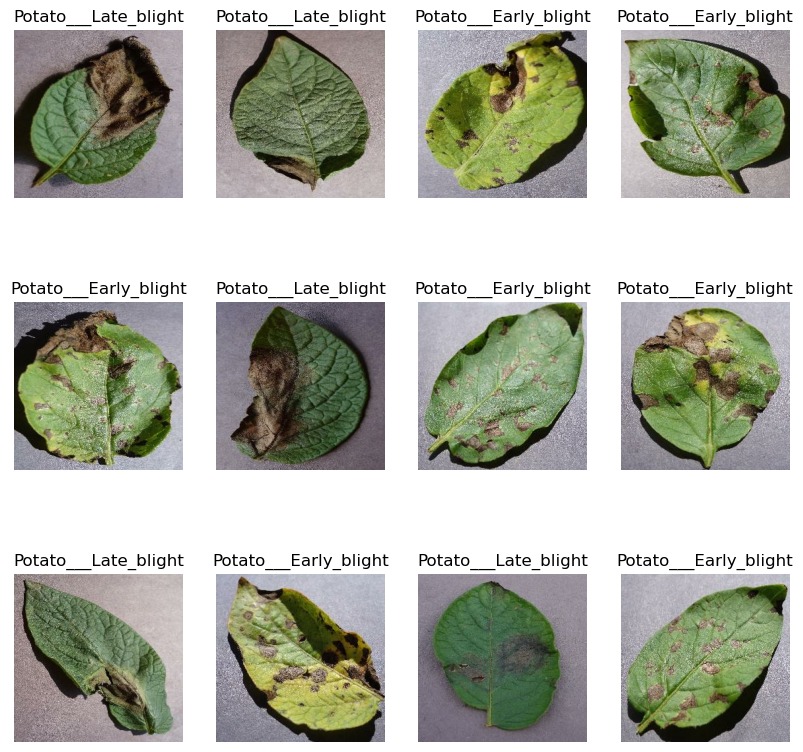

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.5, val_split=0.25, test_split=0.25, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [8]:
print(len(train_ds), len(val_ds), len(test_ds))

34 17 17


In [9]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20
34/34 [==============================] - 48s 1s/step - loss: 0.9163 - accuracy: 0.4697 - val_loss: 0.8766 - val_accuracy: 0.5331
Epoch 2/20
34/34 [==============================] - 47s 1s/step - loss: 0.8024 - accuracy: 0.6057 - val_loss: 0.6078 - val_accuracy: 0.7739
Epoch 3/20
34/34 [==============================] - 47s 1s/step - loss: 0.5446 - accuracy: 0.7702 - val_loss: 0.6086 - val_accuracy: 0.7463
Epoch 4/20
34/34 [==============================] - 47s 1s/step - loss: 0.4813 - accuracy: 0.8024 - val_loss: 0.3466 - val_accuracy: 0.8585
Epoch 5/20
34/34 [==============================] - 48s 1s/step - loss: 0.3484 - accuracy: 0.8502 - val_loss: 0.8649 - val_accuracy: 0.6691
Epoch 6/20
34/34 [==============================] - 48s 1s/step - loss: 0.3259 - accuracy: 0.8787 - val_loss: 0.4218 - val_accuracy: 0.8290
Epoch 7/20
34/34 [==============================] - 48s 1s/step - loss: 0.2829 - accuracy: 0.8897 - val_loss: 0.2187 - val_accuracy: 0.9118
Epoch 8/20
34/34 [==

In [13]:
scores=model.evaluate(test_ds)
scores

17/17 [==============================] - 5s 234ms/step - loss: 0.1538 - accuracy: 0.9393


[0.1538049280643463, 0.939338207244873]

In [14]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [15]:
history.history['loss']

[0.9163076877593994,
 0.802449107170105,
 0.5446094274520874,
 0.48126721382141113,
 0.3483867645263672,
 0.3259257376194,
 0.28290805220603943,
 0.21351662278175354,
 0.22130371630191803,
 0.17074601352214813,
 0.12819711863994598,
 0.13370203971862793,
 0.16560085117816925,
 0.107127845287323,
 0.10683789104223251,
 0.10760265588760376,
 0.09236996620893478,
 0.07926907390356064,
 0.09094782173633575,
 0.05697023123502731]

In [16]:
history.history['accuracy']

[0.4696691036224365,
 0.6056985259056091,
 0.7702205777168274,
 0.8023896813392639,
 0.8501838445663452,
 0.8786764740943909,
 0.8897058963775635,
 0.9099264740943909,
 0.90625,
 0.9310661554336548,
 0.954963207244873,
 0.953125,
 0.9457720518112183,
 0.951286792755127,
 0.9613970518112183,
 0.9568014740943909,
 0.9650735259056091,
 0.96875,
 0.9641544222831726,
 0.9834558963775635]

In [17]:
history.history['val_loss']

[0.8765666484832764,
 0.6077574491500854,
 0.608593225479126,
 0.34663844108581543,
 0.8649322390556335,
 0.42182430624961853,
 0.21870245039463043,
 0.2552509009838104,
 0.29378741979599,
 0.16487935185432434,
 0.12705102562904358,
 0.20746059715747833,
 0.15086214244365692,
 0.22959986329078674,
 0.1832127422094345,
 0.1662004142999649,
 0.19568638503551483,
 0.31001362204551697,
 0.08625606447458267,
 0.1652785837650299]

In [18]:
history.history['val_accuracy']

[0.533088207244873,
 0.7738970518112183,
 0.7463235259056091,
 0.8584558963775635,
 0.6691176295280457,
 0.8290441036224365,
 0.9117646813392639,
 0.908088207244873,
 0.8658088445663452,
 0.9448529481887817,
 0.9466911554336548,
 0.9319853186607361,
 0.9503676295280457,
 0.9191176295280457,
 0.9283088445663452,
 0.9430146813392639,
 0.935661792755127,
 0.8988970518112183,
 0.96875,
 0.9485294222831726]

In [19]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

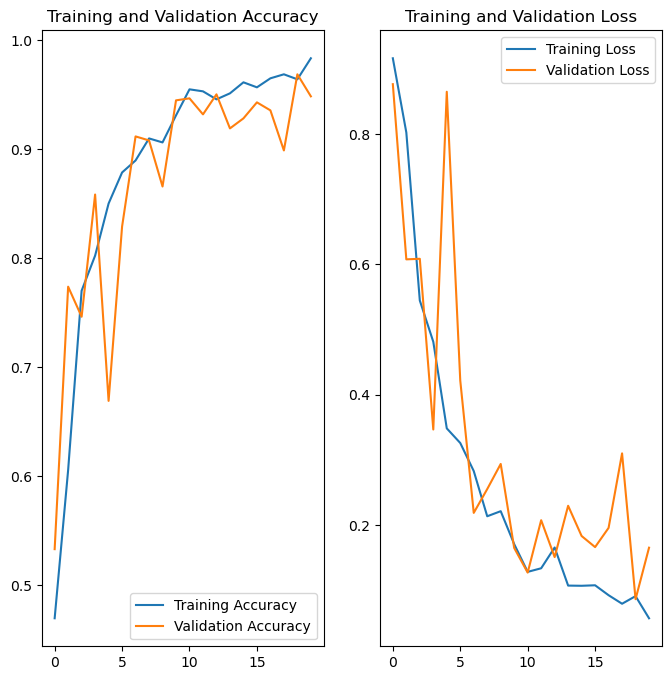

In [20]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [22]:
true_labels = []
pred_labels = []
for images_batch, labels_batch in test_ds.take(17):
    batch_prediction=model.predict(images_batch).argmax(axis=1)
    for i in labels_batch:
        true_labels.append(i)
    for i in batch_prediction:
        pred_labels.append(i)

1/1 [==============================] - 0s 312ms/step


In [23]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 36ms/step


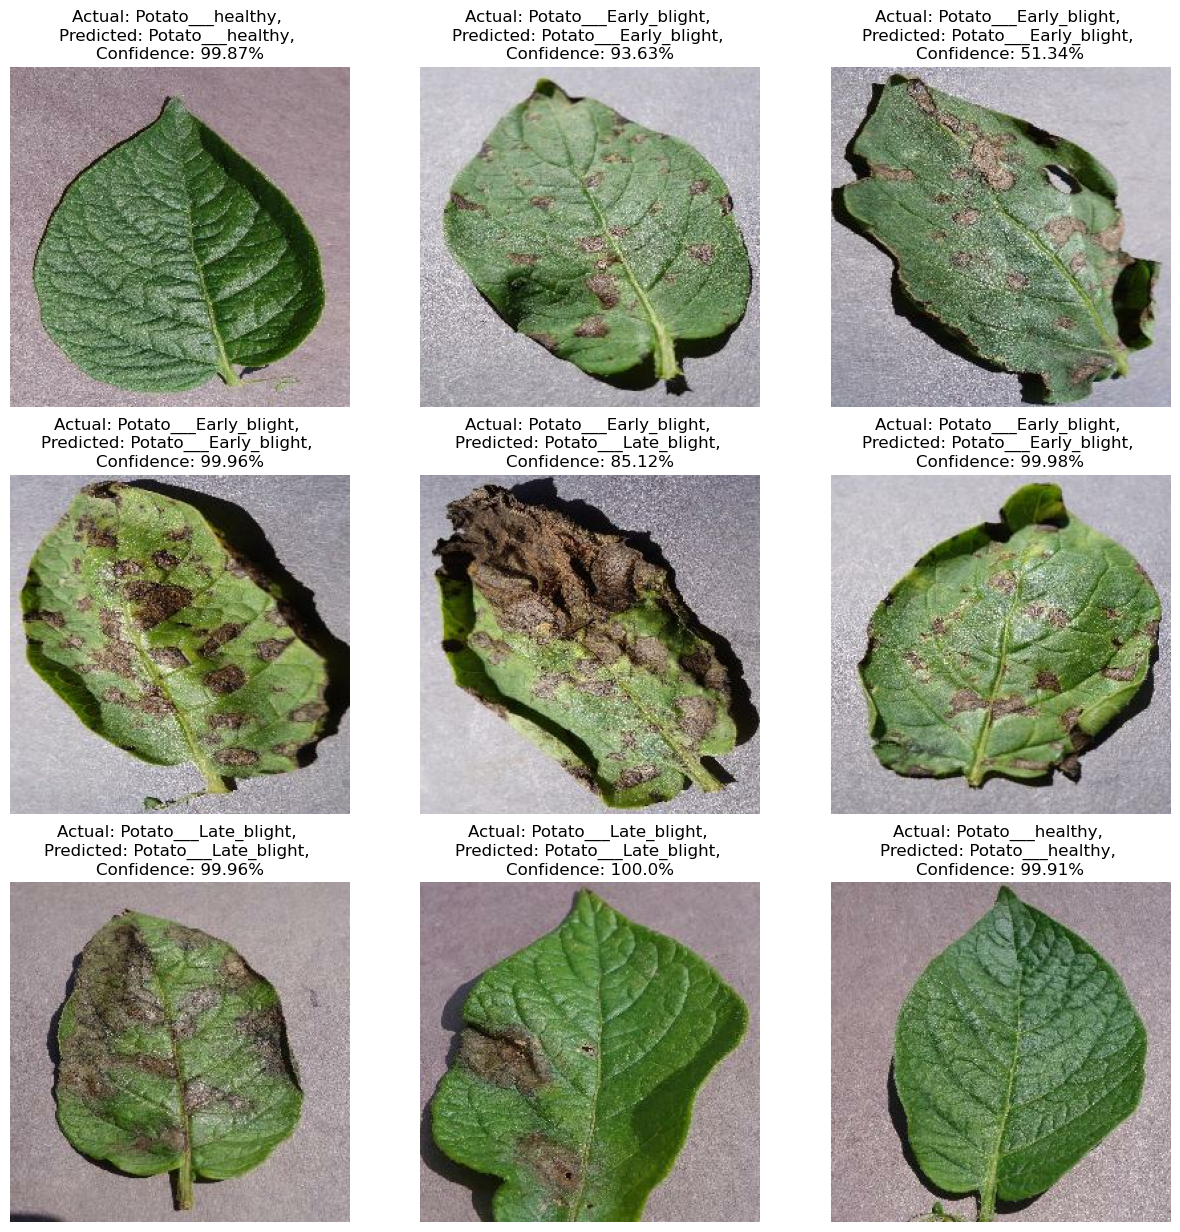

In [24]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}%")
        plt.axis("off")

In [25]:
print ("Classification Report: \n", classification_report(true_labels, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.89      0.94       258
           1       0.89      0.99      0.94       249
           2       0.92      0.95      0.93        37

    accuracy                           0.94       544
   macro avg       0.94      0.94      0.94       544
weighted avg       0.94      0.94      0.94       544



In [26]:
cm=tf.math.confusion_matrix(true_labels, pred_labels)
cm

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[230,  28,   0],
       [  0, 246,   3],
       [  0,   2,  35]])>

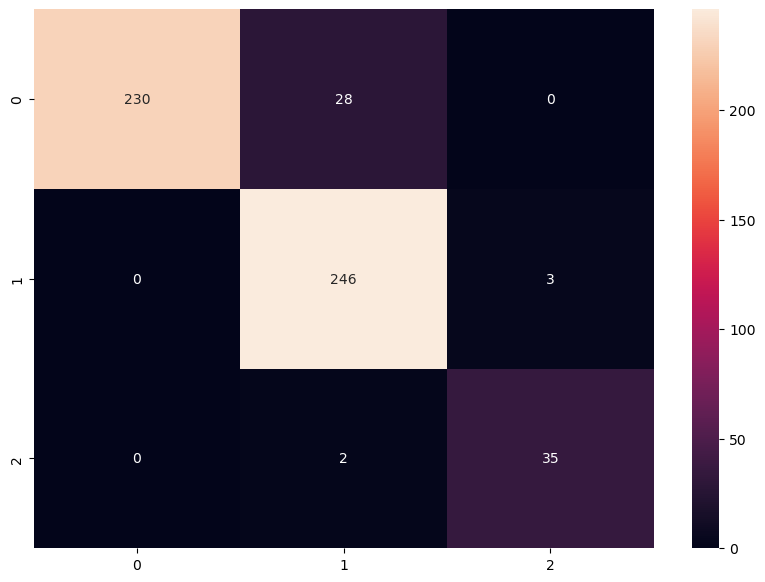

In [27]:
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel=('Predicted')
plt.ylabel=('Truth')

In [28]:
filename = "Model1-DatasetSplit50-25-25.joblib"
joblib.dump(model, filename)

['Model1-DatasetSplit50-25-25.joblib']